# Calculate AEP by storm type

Calculate the AEP wind speeds by storm type, even for short records

In [1]:
%matplotlib inline


from os.path import join as pjoin, exists

import pandas as pd
import numpy as np
from scipy.stats import genpareto
from scipy.optimize import curve_fit
from statsmodels.nonparametric.kde import KDEUnivariate

import seaborn as sns
import matplotlib.pyplot as plt

from stndata import ONEMINUTESTNDTYPE, ONEMINUTESTNNAMES


In [2]:
BASEDIR = r"X:\georisk\HaRIA_B_Wind\data\derived\obs\1-minute\events-60"
OUTPUTPATH = pjoin(BASEDIR, "results")
stormdf = pd.read_pickle(pjoin(OUTPUTPATH, "stormclass.pkl"))
allstnfile = r"X:\georisk\HaRIA_B_Wind\data\raw\from_bom\2022\1-minute\HD01D_StationDetails.txt"
allstndf = pd.read_csv(allstnfile, sep=',', index_col='stnNum',
                       names=ONEMINUTESTNNAMES,
                       keep_default_na=False,
                       converters={
                            'stnName': str.strip,
                            'stnState': str.strip,
                            'stnDataStartYear': lambda s: int(float(s.strip() or 0)),
                            'stnDataEndYear': lambda s: int(float(s.strip() or 0))
                        })
allstndf['timespan'] = allstndf['stnDataEndYear'] - allstndf['stnDataStartYear']

In [3]:
def loadDailyMaxData(stnNum: int) -> pd.DataFrame:
    """
    Load daily maximum wind gust data for a given station

    :param stnNum: Station identification number
    :type stnNum: int
    :return: `pd.DataFrame` containing daily maximum wind gust data for the station, along with other variables associated with the gust event.
    :rtype: pd.DataFrame
    """
    try:
        df = pd.read_pickle(pjoin(BASEDIR, 'dailymax', f"{stnNum:06d}.pkl"))
    except FileNotFoundError:
        print(f"No data for station {stnNum}")
    df = df.reset_index(drop=False).set_index(['stnNum', 'date'])
    return df

In [4]:
alldflist = []
for stn in allstndf.index:
    if exists(pjoin(BASEDIR, 'dailymax', f"{stn:06d}.pkl")):
        df = loadDailyMaxData(stn)
        alldflist.append(df)
    else:
        print(f"No data for station {stn}")
    
alldf = pd.concat(alldflist)
alldf.reset_index(drop=False, inplace=True)
alldf['date'] = pd.to_datetime(alldf.date)
alldf.set_index(['stnNum', 'date'], inplace=True)

No data for station 87185
No data for station 66198
No data for station 66199
No data for station 66200
No data for station 66201
No data for station 66202
No data for station 66203
No data for station 60168


In [5]:
datadf = stormdf.join(alldf, on=['stnNum', 'date'], how='inner')

Storms with a gust wind speed over 150 km/h and a gust ratio > 9.0 (about the 98th percentile of gust ratio values) are considered spurious and reclassified as "Unclassified".

In [6]:
datadf.loc[(datadf.windgust>150) & (datadf.gustratio > 9.0) & (~datadf.stormType.isin(['Spike', 'Unclassified'])), 'stormType'] = 'Unclassified'

In [7]:
tsGust = datadf.loc[datadf.stormType.isin(['Thunderstorm', 'Front up', 'Front down'])]
synGust = datadf.loc[datadf.stormType.isin(['Synoptic storm', 'Synoptic front', 'Storm-burst'])]

In [ ]:
def empiricalPDF(data):
    """
    Evaluate a probability density function using kernel density
    estimation for input data.

    :param data: :class:`numpy.ndarray` of data values.

    :returns: PDF values at the data points.
    """
    sortedmax = np.sort(data)
    kde = KDEUnivariate(sortedmax)
    kde.fit()
    try:
        res = kde.evaluate(sortedmax)
    except MemoryError:
        res = np.zeros(len(sortedmax))
    return res

def fitGPD(x, mu, xi, sigma):
    emppdf = empiricalPDF(x)
    popt, pcov = curve_fit(lambda x, xi, sigma: genpareto.pdf(x, xi, loc=mu, scale=sigma), np.sort(x), emppdf, (xi, sigma))
    return popt, pcov

We now fit a generalised pareto distribution (GPD) to each station and each broad group of storm type (i.e. convective & non-convective). 

Use a fixed shape parameter (approach used in AS/NZS 1170.2), and set the initial location parameter to match the minimum wind speed (60 km/h)

In [ ]:
tsgpdparams = pd.DataFrame(columns=['mu', 'xi', 'sigma'])
for stn, tmpdf in tsGust.groupby('stnNum'):
    x = tmpdf['windgust'].values
    xi, mu, sigma = genpareto.fit(np.sort(x),fc=0.1, loc=x.min())
    # print(f"STN: {stn} | mu: {mu}, xi: {xi}, sigma {sigma}")
    tsgpdparams.loc[stn] = pd.Series({'mu': mu, 'xi': xi, 'sigma': sigma}, name=stn)

In [ ]:
syngpdparams = pd.DataFrame(columns=['mu', 'xi', 'sigma'])
for stn, tmpdf in synGust.groupby('stnNum'):
    x = tmpdf['windgust'].values
    xi, mu, sigma = genpareto.fit(np.sort(x),fc=0.1, loc=x.min())
    syngpdparams.loc[stn] = pd.Series({'mu': mu, 'xi': xi, 'sigma': sigma}, name=stn)

As a demonstration, we plot the fitted GP distributions for convective/non-convective wind gusts for an individual station, using the fixed shape parameter. 

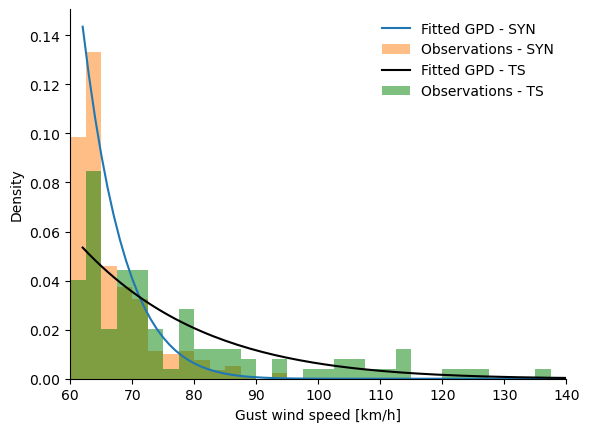

In [44]:
swspd = np.sort(synGust[synGust.stnNum==41359]['windgust'].values)
sshp, sloc, sscl = genpareto.fit(swspd, fc=-0.1, loc=swspd.min())
x = np.arange(62, 200)
fig, ax = plt.subplots(1, 1)
ax.plot(x, genpareto.pdf(x, sshp, loc=sloc, scale=sscl), label="Fitted GPD - SYN")
ax.hist(swspd, density=True, alpha=0.5, label="Observations - SYN", bins=np.arange(60, 200, 2.5))
ax.set_xlim(60, 10*(int(swspd.max()/10) + 1))
ax.set_xlabel("Gust wind speed [km/h]")
ax.set_ylabel("Density")
ax.legend(frameon=False)

twspd = np.sort(tsGust[tsGust.stnNum==41359]['windgust'].values)
tshp, tloc, tscl = genpareto.fit(twspd, fc=-0.1, loc=twspd.min())
x = np.arange(62, 200)
ax.plot(x, genpareto.pdf(x, tshp, loc=tloc, scale=tscl), color='k', label="Fitted GPD - TS")
ax.hist(twspd, density=True, color='g', alpha=0.5, label="Observations - TS",
        bins=np.arange(60, 200, 2.5))
ax.set_xlim(60, 10*(int(twspd.max()/10) + 1))
ax.set_xlabel("Gust wind speed [km/h]")
ax.set_ylabel("Density")
ax.legend(frameon=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)



Text(0, 0.5, 'Gust wind speed [km/h]')

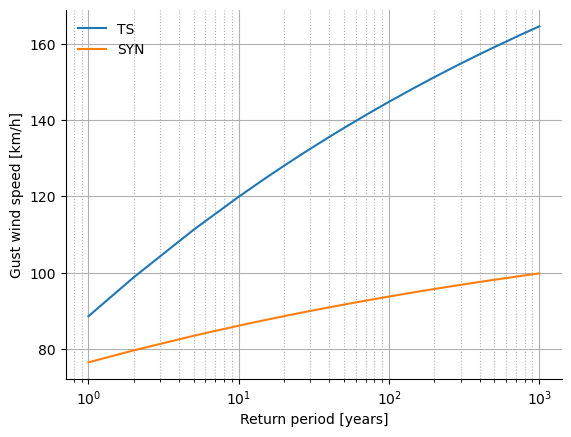

In [53]:
intervals = np.array([1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
npyr = 365.25
srate = float(len(swspd))/(allstndf.loc[41359]['timespan']*npyr)
trate = float(len(twspd))/(allstndf.loc[41359]['timespan']*npyr)
trl = tloc + (tscl / tshp) * (np.power(intervals * npyr * trate, tshp) - 1.)
srl = sloc + (sscl / sshp) * (np.power(intervals * npyr * srate, sshp) - 1.)

fig, ax = plt.subplots(1, 1)
ax.semilogx(intervals, trl, label="TS")
ax.semilogx(intervals, srl, label='SYN')
ax.legend(frameon=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel("Return period [years]")
ax.set_ylabel("Gust wind speed [km/h]")

Text(0, 0.5, 'Annual probability')

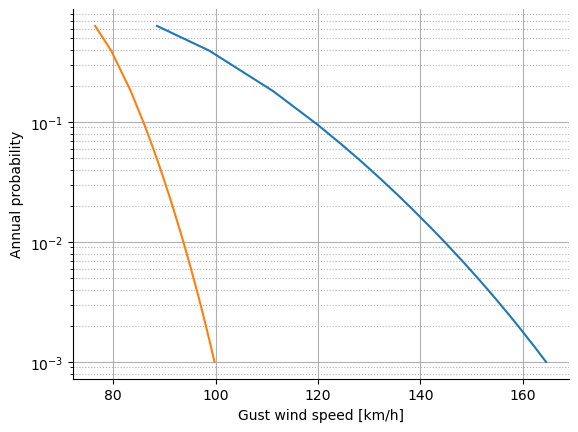

In [54]:
aep = 1.0 - np.exp(-1.0/intervals)

fig, ax = plt.subplots(1, 1)
ax.semilogy(trl, aep)
ax.semilogy(srl, aep)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.grid(which='major', linestyle='-')
ax.grid(which='minor', linestyle=':')
ax.set_xlabel("Gust wind speed [km/h]")
ax.set_ylabel("Annual probability")

Combined AEP wind speeds:

$AEP_{c} = 1 - (1 - AEP_{TS})(1 - AEP_{SYN})$